# 869 Assignment 1 

TODO: Fill in the information below:

- [David, Hu]
- [20249146]
- [Question 7, Task 2]
- [MMA]
- [2021S]
- [MMA869]
- [Dec/13/2020]

<b>Table of Contents</b>
<ul>
    <li><a href="#DataExploration">Data Exploration</a></li>
    <li><a href="#DataPreparation">Data Preparation</a></li>
    <li><a href="#Imbalance">Imbalance</a></li>
    <li><a href="#Models">Models</a>
        <ul>
        <li><a href="#Logistic-Regression">Logistic Regression</a></li>
        <li><a href="#Random-Forest">Random Forest</a></li>
        <li><a href="#KNN">KNN</a></li>
        </ul>
    </li>
    <li><a href="#Model-Comparison">Model Comparison</a></li>
</ul>

In [1]:
# Do not change this cell

import datetime
print(datetime.datetime.now())

2020-12-10 22:28:07.134776


In [2]:
# Do not change this cell

import pandas as pd
import numpy as np
import sklearn

print('scikit-learn: {}'.format(sklearn.__version__))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

scikit-learn: 0.23.2
pandas: 1.1.3
numpy: 1.19.2


In [3]:
# Do not change this cell

import os
os.getcwd()

"/Users/dvdhoo/OneDrive - Queen's University/MMA/MMA 869/Individual Assignment/Answers"

In [4]:
# TODO: Import other packages as necessary
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score
from sklearn.metrics import log_loss, confusion_matrix, recall_score, precision_score

In [5]:
# Read in the data
df = pd.read_csv("../OJ.csv") # or whatever file you need

In [6]:
# TODO: continue here to perform the given task. 
# Don't forget to document your code!
# Use as many cells as you'd like!
# Don't print out large volumes of output!
# Don't forget to save/export as PDF!
# Make sure to always run all cells in order! Always restart kernel and run all cells before creating the PDF

In [7]:
# Hyperparameter Tuning Results Helper
def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    results['mean_fit_time'] = cv_results['mean_fit_time']
    results['mean_score_time'] = cv_results['mean_score_time']
    results['mean_train_score'] = cv_results['mean_train_score']
    results['std_train_score'] = cv_results['std_train_score']
    results['mean_test_score'] = cv_results['mean_test_score']
    results['std_test_score'] = cv_results['std_test_score']
    results['rank_test_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_test_score'], ascending=False)
    return results

In [8]:
# Model Performance Metrics Helper
def cv_score(y_test, y_pred, y_prob, sprint):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy       = accuracy_score(y_test, y_pred)
    f1             = f1_score(y_test, y_pred)
    f1n            = f1_score(y_test, y_pred, pos_label=0)
    macrof1        = f1_score(y_test, y_pred, average='macro')
    recall         = recall_score(y_test, y_pred)
    precision      = precision_score(y_test, y_pred)
    recall_n       = recall_score(y_test, y_pred, pos_label=0)
    precision_n    = precision_score(y_test, y_pred, pos_label=0)
    roc_auc        = roc_auc_score(y_test, y_prob)
    
    df = pd.DataFrame({"Sprint"    : [sprint],
                       "Neg"       : [tn + fn],
                       "TN"  : [tn],
                       "FN" : [fn],
                       "Pos"       : [tp + fp],
                       "TP"        : [tp],
                       "FP"        : [fp],
                       "Accuracy"  : [accuracy],
                       "Recall"    : [recall],
                       "Precision" : [precision],
                       "Recall 0"  : [recall_n],
                       "Precision 0":[precision_n],
                       "F1"        : [f1],
                       "F1 0"      : [f1n],
                       "Macro F1"  : [macrof1],
                       "AUC"       : [roc_auc],
                      })
    
    return df

score_list = ["Sprint", "Neg", "TN", "FN", "Pos", "TP", "FP",
              "Accuracy", "Recall", "Precision", "Recall 0", "Precision 0",
              "F1", "F1 0", "Macro F1", "AUC"]

In [9]:
# TimeSeries Cross Validation Helper
def train_tscv(X, y, clf, tscv):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(10, 8))

    dt_score = pd.DataFrame(columns=score_list)

    # Cross Validation Sprints
    i = 0
    for train_index, test_index in tscv.split(X):
        i = i+1

        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        print("\n===========================================================")
        print("Split {}".format(i))
        #print(train_index)
        #print(test_index)
        print("X_train shape: {}".format(X_train.shape))
        print("X_train weeks min/max: {}, {}".format(X_train['WeekofPurchase'].min(),
                                                     X_train['WeekofPurchase'].max()))
        print("X_test shape: {}".format(X_test.shape))
        print("X_test  weeks min/max: {}, {}".format(X_test['WeekofPurchase'].min(),
                                                     X_test['WeekofPurchase'].max()))

        clf = clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_prob = pd.DataFrame(clf.predict_proba(X_test))[1]

        # ROC Curves
        viz = plot_roc_curve(clf, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # Performance Metrics
        print("\nF1 Score  = {:.2f}".format(f1_score(y_test, y_pred, average="macro")))
        print("Accuracy   = {:.2f}".format(accuracy_score(y_test, y_pred)))
        print("Kappa      = {:.2f}".format(cohen_kappa_score(y_test, y_pred)))
        print("Log Loss   = {:.2f}".format(log_loss(y_test, y_pred)))
        print("\nConfusion Matrix:")
        unique_label = np.unique([y_test, y_pred])
        cmtx = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=unique_label), 
        index=['true:{:}'.format(x) for x in unique_label], 
        columns=['pred:{:}'.format(x) for x in unique_label])
        print(cmtx)
        dt_score = dt_score.append(cv_score(y_test, y_pred, y_prob, i))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred)) 

    # Plot ROCs
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="{} ROC Curve".format(str(clf).partition("(")[0]))
    ax.legend(loc="lower right")
    plt.show()
    
    # Results
    tempdt = dt_score.mean()
    tempdt["Sprint"] = 'Mean'
    dt_score = dt_score.append(tempdt, ignore_index=True)
    
    return dt_score

In [10]:
# Sampling Helper

def sampling_evaluate(X_train, X_test, y_train, y_test):
    
    evals = list()
    resampe_methods = ['Base', 'Class Weights', RandomOverSampler, SMOTE, ADASYN, RandomUnderSampler]
    names = ['Base', 'Class Weights', 'Over Sample', 'Over SMOTE', 'Over ADASYN', 'Under Sample']
    
    for i in range(0,6):
        method = resampe_methods[i]
        name = names[i]
        cw = None
        X_resampled, y_resampled = X_train, y_train

        if method =='Class Weights':
            cw = 'balanced'
        elif method == 'Base':
            pass
        else:
            resample_method = method
            X_resampled, y_resampled = resample_method(random_state=0).fit_resample(X_train.to_numpy(), y_train)

        clf = DecisionTreeClassifier(random_state=0, class_weight=cw)
        #clf = LogisticRegression(max_iter=1000, class_weight=cw, random_state=0)

        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test)
        y_prob = pd.DataFrame(clf.predict_proba(X_test))[1]

        df = cv_score(y_test, y_pred, y_prob, 0)
        df = df.drop("Sprint", axis=1)
        df_temp = pd.DataFrame([name], columns=['Method'])
        df = df_temp.merge(df, left_index=True, right_index=True)
        evals.append(df)
    
    evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

    evals_all = evals_all.drop(columns = "index",axis =1)
    evals_all = evals_all.sort_values(by=['Macro F1'], ascending=False)
    
    return evals_all

# DataExploration

In [11]:
df

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,Purchase
0,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,CH
1,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,CH
2,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,CH
3,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,MM
4,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,CH
...,...,...,...,...,...,...,...,...,...,...
1065,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,CH
1066,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,CH
1067,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,MM
1068,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,CH


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WeekofPurchase  1070 non-null   int64  
 1   StoreID         1070 non-null   int64  
 2   PriceCH         1070 non-null   float64
 3   PriceMM         1070 non-null   float64
 4   DiscCH          1070 non-null   float64
 5   DiscMM          1070 non-null   float64
 6   SpecialCH       1070 non-null   int64  
 7   SpecialMM       1070 non-null   int64  
 8   LoyalCH         1070 non-null   float64
 9   Purchase        1070 non-null   object 
dtypes: float64(5), int64(4), object(1)
memory usage: 83.7+ KB


In [13]:
# Check imbalance
df['Purchase'].value_counts()

CH    653
MM    417
Name: Purchase, dtype: int64

In [14]:
# Check time series
df['WeekofPurchase'].is_monotonic_increasing

False

In [15]:
df_explore = df[['WeekofPurchase','PriceCH', 'PriceMM', 'DiscCH', 'DiscMM']]
df_explore = df_explore.groupby('WeekofPurchase').agg("mean")

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Price')

Text(0.5, 0, 'Week')

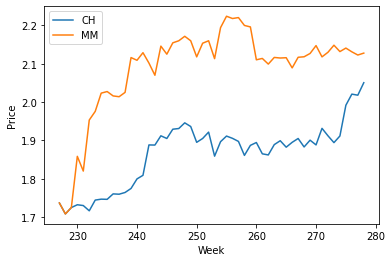

In [16]:
# Plotting price changes over time

plt.figure(figsize=(6, 4))
plt.plot(df_explore.index, df_explore['PriceCH'], label='CH')
plt.plot(df_explore.index, df_explore['PriceMM'], label='MM')
plt.ylabel('Price')
plt.xlabel('Week')
plt.legend(loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Discount')

Text(0.5, 0, 'Week')

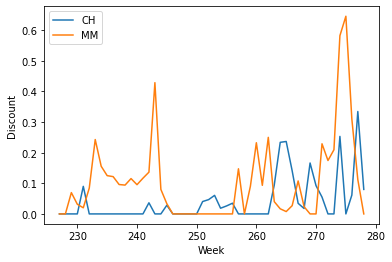

In [17]:
# Plotting discount changes over time

plt.figure(figsize=(6, 4))
plt.plot(df_explore.index, df_explore['DiscCH'], label='CH')
plt.plot(df_explore.index, df_explore['DiscMM'], label='MM')
plt.ylabel('Discount')
plt.xlabel('Week')
plt.legend(loc='upper left')
plt.show()

# DataPreparation

<b>Task 2a.</b>

The "Purchase" column is a categorical feature encoded in strings. I used one hot encoder to dummify this feature. 1 means the customer purchased CH, and 0 means MM. I sorted the data by "WeekofPurchase" to make it time sequenced. I split the new "Purchase_CH" feature as y, and leave the rest in X.

In [18]:
df_copy = df.copy()

# One Hot Encoder
cat_attrs = df_copy.select_dtypes(include=[np.object]).columns
OHE = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False)
OHE.fit(df_copy[cat_attrs])
cat_feature_names = list(OHE.get_feature_names(cat_attrs))
df_copy_cat = pd.DataFrame(OHE.transform(df_copy[cat_attrs]), columns=cat_feature_names)
df_copy = pd.concat([df_copy, df_copy_cat], axis=1, sort=False)
df_copy = df_copy.drop(['Purchase', 'Purchase_MM'], axis=1)

# Sort by Week
df_copy = df_copy.sort_values('WeekofPurchase')
df_copy.reset_index(drop=True)

OneHotEncoder(handle_unknown='ignore', sparse=False)

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,Purchase_CH
0,227,2,1.69,1.69,0.0,0.0,0,0,0.744000,1.0
1,227,1,1.69,1.69,0.0,0.0,0,0,0.600000,1.0
2,227,4,1.79,1.79,0.0,0.0,0,1,0.500000,0.0
3,227,2,1.69,1.69,0.0,0.0,0,0,0.258395,0.0
4,227,2,1.69,1.69,0.0,0.0,0,0,0.211886,0.0
...,...,...,...,...,...,...,...,...,...,...
1065,278,2,1.99,2.18,0.0,0.0,0,0,0.716229,1.0
1066,278,3,2.09,2.09,0.2,0.0,0,0,0.986489,1.0
1067,278,3,2.09,2.09,0.2,0.0,0,0,0.995388,1.0
1068,278,7,2.06,2.13,0.0,0.0,0,0,0.067109,0.0


In [19]:
df_copy['WeekofPurchase'].is_monotonic_increasing

True

In [20]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 97 to 73
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WeekofPurchase  1070 non-null   int64  
 1   StoreID         1070 non-null   int64  
 2   PriceCH         1070 non-null   float64
 3   PriceMM         1070 non-null   float64
 4   DiscCH          1070 non-null   float64
 5   DiscMM          1070 non-null   float64
 6   SpecialCH       1070 non-null   int64  
 7   SpecialMM       1070 non-null   int64  
 8   LoyalCH         1070 non-null   float64
 9   Purchase_CH     1070 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 92.0 KB


In [21]:
df_copy.corr().round(decimals=4)

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,Purchase_CH
WeekofPurchase,1.0000,0.0960,0.7043,0.5769,0.3657,0.2423,0.1079,0.0707,0.1929,0.1256
StoreID,0.0960,1.0000,0.0208,0.0933,0.3332,0.0106,0.3794,-0.1716,0.2373,0.2526
PriceCH,0.7043,0.0208,1.0000,0.6164,0.1519,0.1163,-0.0991,-0.0180,0.0778,0.0230
PriceMM,0.5769,0.0933,0.6164,1.0000,0.0652,-0.0012,-0.0313,-0.0683,0.1156,0.1492
DiscCH,0.3657,0.3332,0.1519,0.0652,1.0000,0.0180,0.5348,-0.0470,0.1394,0.1812
DiscMM,0.2423,0.0106,0.1163,-0.0012,0.0180,1.0000,0.1566,0.4658,-0.0203,-0.1669
SpecialCH,0.1079,0.3794,-0.0991,-0.0313,0.5348,0.1566,1.0000,-0.1542,0.1371,0.1328
SpecialMM,0.0707,-0.1716,-0.0180,-0.0683,-0.0470,0.4658,-0.1542,1.0000,-0.0882,-0.1748
LoyalCH,0.1929,0.2373,0.0778,0.1156,0.1394,-0.0203,0.1371,-0.0882,1.0000,0.6406
Purchase_CH,0.1256,0.2526,0.0230,0.1492,0.1812,-0.1669,0.1328,-0.1748,0.6406,1.0000


In [22]:
# X y data
target_col = 'Purchase_CH'

X = df_copy.drop(target_col, axis=1)
y = df_copy[target_col]

In [23]:
# Train Test Split for cross validation

tscv = TimeSeriesSplit(n_splits=5)

<b>Task 2b.</b>

This training/testing data split is a time series split of 5 folds.
Choosing time series split is because of the "WeekofPurchase" feature which gives a time dimension to this data. To avoid target leakage. It doesn't seem to matter too much in this data, but I did it just in case.
I choose 5 folds because there are 1070 instances, with each split having about 200 instances.

# Imbalance

In [24]:
# 80/20 Split
train_index, test_index = range(0, 856), range(856, 1070)
    
X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Evaluate resampling methods
sampling_evaluate(X_train, X_test, y_train, y_test)

,Method,Neg,TN,FN,Pos,TP,FP,Accuracy,Recall,Precision,Recall 0,Precision 0,F1,F1 0,Macro F1,AUC
0,Base,71,50,21,143,107,36,0.733645,0.835938,0.748252,0.581395,0.704225,0.789668,0.636943,0.713305,0.708666
1,Class Weights,75,49,26,139,102,37,0.705607,0.796875,0.733813,0.569767,0.653333,0.764045,0.608696,0.686370,0.684366
3,Over SMOTE,112,65,47,102,81,21,0.682243,0.632812,0.794118,0.755814,0.580357,0.704348,0.656566,0.680457,0.694313
5,Under Sample,67,41,26,147,102,45,0.668224,0.796875,0.693878,0.476744,0.611940,0.741818,0.535948,0.638883,0.636810
2,Over Sample,72,42,30,142,98,44,0.654206,0.765625,0.690141,0.488372,0.583333,0.725926,0.531646,0.628786,0.626999
4,Over ADASYN,128,59,69,86,59,27,0.551402,0.460938,0.686047,0.686047,0.460938,0.551402,0.551402,0.551402,0.573492


# Models
<b>Task 2c.</b>

The three models of choice is <b>Logistic Regression</b>, <b>Random Forest</b> and <b>KNN</b>.

## Logistic Regression

In [25]:
# Class Weight Balancing Test

params = {"class_weight": [None, 'balanced']
         }

clf = LogisticRegression(max_iter=1000, random_state=42)
gridsearch = GridSearchCV(clf, param_grid=params, 
                          cv=5, scoring='f1_macro', return_train_score=True)

# 80/20 Split
train_index, test_index = range(0, 856), range(856, 1070)
    
X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

%time gridsearch.fit(X_train, y_train)

y_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred))

CPU times: user 2.51 s, sys: 15.9 ms, total: 2.52 s
Wall time: 640 ms


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'class_weight': [None, 'balanced']},
             return_train_score=True, scoring='f1_macro')

              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74        86
         1.0       0.82      0.87      0.84       128

    accuracy                           0.80       214
   macro avg       0.80      0.79      0.79       214
weighted avg       0.80      0.80      0.80       214



In [26]:
# Print out the results of hyperparmater tuning in a table.

cv_results_to_df(gridsearch.cv_results_)
gridsearch.best_params_
gridsearch.best_score_
gridsearch.best_estimator_

,class_weight,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
1,balanced,0.048811,0.001996,0.822580,0.009290,0.772624,0.095850,1
0,None,0.054757,0.002021,0.819446,0.011704,0.760446,0.063222,2


{'class_weight': 'balanced'}

0.7726244812531975

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)


Split 1
X_train shape: (180, 9)
X_train weeks min/max: 227, 235
X_test shape: (178, 9)
X_test  weeks min/max: 236, 245

F1 Score  = 0.81
Accuracy   = 0.81
Kappa      = 0.62
Log Loss   = 6.60

Confusion Matrix:
          pred:0.0  pred:1.0
true:0.0        75        14
true:1.0        20        69

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        89
         1.0       0.83      0.78      0.80        89

    accuracy                           0.81       178
   macro avg       0.81      0.81      0.81       178
weighted avg       0.81      0.81      0.81       178


Split 2
X_train shape: (358, 9)
X_train weeks min/max: 227, 245
X_test shape: (178, 9)
X_test  weeks min/max: 245, 257

F1 Score  = 0.78
Accuracy   = 0.80
Kappa      = 0.56
Log Loss   = 6.99

Confusion Matrix:
          pred:0.0  pred:1.0
true:0.0        44        11
true:1.0        25        98

Classification Report:
              precision    re

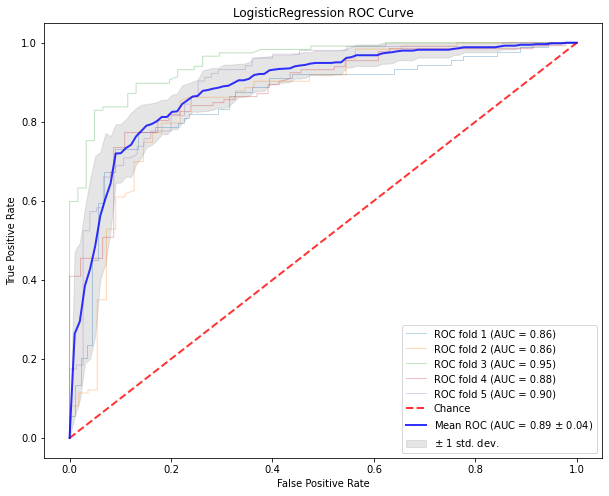

In [27]:
# LR CV

clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
result_lr = train_tscv(X, y, clf, tscv)

In [28]:
# LR CV results

result_lr.iloc[:,0:12]

,Sprint,Neg,TN,FN,Pos,TP,FP,Accuracy,Recall,Precision,Recall 0,Precision 0
0,1,95,75,20,83,69,14,0.808989,0.775281,0.831325,0.842697,0.789474
1,2,69,44,25,109,98,11,0.797753,0.796748,0.899083,0.800000,0.637681
2,3,42,39,3,136,114,22,0.859551,0.974359,0.838235,0.639344,0.928571
3,4,46,29,17,132,115,17,0.808989,0.871212,0.871212,0.630435,0.630435
4,5,72,57,15,106,88,18,0.814607,0.854369,0.830189,0.760000,0.791667
5,Mean,64.8,48.8,16,113.2,96.8,16.4,0.817978,0.854394,0.854009,0.734495,0.755566


In [29]:
result_lr.iloc[:,[0,12,13,14,15]]

,Sprint,F1,F1 0,Macro F1,AUC
0,1,0.802326,0.815217,0.808771,0.855321
1,2,0.844828,0.709677,0.777253,0.856171
2,3,0.901186,0.757282,0.829234,0.952921
3,4,0.871212,0.630435,0.750823,0.878047
4,5,0.842105,0.775510,0.808808,0.899612
5,Mean,0.852331,0.737624,0.794978,0.888415


## Random Forest

In [30]:
# Hyperparameter Tuning

params = {"criterion":      ["gini", "entropy"],
          "max_depth":      np.arange(2, 6),
          "max_features":   np.arange(1, 9),
          "max_leaf_nodes": np.arange(6, 10),
         }

clf = RandomForestClassifier(random_state=42)
gridsearch = GridSearchCV(clf, param_grid=params, 
                          cv=5, scoring='f1_macro', return_train_score=True)

# 80/20 Split
train_index, test_index = range(0, 856), range(856, 1070)
    
X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

%time gridsearch.fit(X_train, y_train)

y_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred))

CPU times: user 2min 28s, sys: 1.22 s, total: 2min 29s
Wall time: 2min 29s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'max_leaf_nodes': array([6, 7, 8, 9])},
             return_train_score=True, scoring='f1_macro')

              precision    recall  f1-score   support

         0.0       0.76      0.66      0.71        86
         1.0       0.79      0.86      0.82       128

    accuracy                           0.78       214
   macro avg       0.78      0.76      0.77       214
weighted avg       0.78      0.78      0.78       214



In [31]:
# Print out the results of hyperparmater tuning in a table.

cv_results_to_df(gridsearch.cv_results_)
gridsearch.best_params_
gridsearch.best_score_
gridsearch.best_estimator_

,criterion,max_depth,max_features,max_leaf_nodes,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
157,entropy,2,8,7,0.099136,0.007423,0.809535,0.009022,0.801875,0.031404,1
158,entropy,2,8,8,0.099739,0.007464,0.809535,0.009022,0.801875,0.031404,1
159,entropy,2,8,9,0.099102,0.007854,0.809535,0.009022,0.801875,0.031404,1
156,entropy,2,8,6,0.097482,0.007674,0.809535,0.009022,0.801875,0.031404,1
154,entropy,2,7,8,0.093637,0.007186,0.810352,0.008501,0.795011,0.040083,5
...,...,...,...,...,...,...,...,...,...,...,...
162,entropy,3,1,8,0.082715,0.008043,0.792821,0.037343,0.455890,0.100949,251
1,gini,2,1,7,0.091919,0.008090,0.692621,0.017538,0.450287,0.123952,253
3,gini,2,1,9,0.083842,0.008025,0.692621,0.017538,0.450287,0.123952,253
2,gini,2,1,8,0.088833,0.008382,0.692621,0.017538,0.450287,0.123952,253


{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 8,
 'max_leaf_nodes': 6}

0.8018745919337704

RandomForestClassifier(criterion='entropy', max_depth=2, max_features=8,
                       max_leaf_nodes=6, random_state=42)


Split 1
X_train shape: (180, 9)
X_train weeks min/max: 227, 235
X_test shape: (178, 9)
X_test  weeks min/max: 236, 245

F1 Score  = 0.81
Accuracy   = 0.81
Kappa      = 0.63
Log Loss   = 6.40

Confusion Matrix:
          pred:0.0  pred:1.0
true:0.0        75        14
true:1.0        19        70

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82        89
         1.0       0.83      0.79      0.81        89

    accuracy                           0.81       178
   macro avg       0.82      0.81      0.81       178
weighted avg       0.82      0.81      0.81       178


Split 2
X_train shape: (358, 9)
X_train weeks min/max: 227, 245
X_test shape: (178, 9)
X_test  weeks min/max: 245, 257

F1 Score  = 0.76
Accuracy   = 0.78
Kappa      = 0.53
Log Loss   = 7.76

Confusion Matrix:
          pred:0.0  pred:1.0
true:0.0        48         7
true:1.0        33        90

Classification Report:
              precision    re

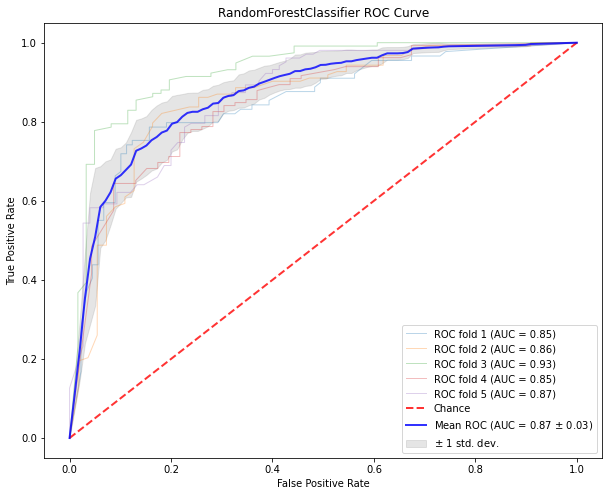

In [32]:
# Random Forest CV

rf = RandomForestClassifier(max_depth=2, max_features=8,
                             max_leaf_nodes=6, random_state=42)
result_rf = train_tscv(X, y, rf, tscv)

In [33]:
# RF CV results

result_rf.iloc[:,0:12]

,Sprint,Neg,TN,FN,Pos,TP,FP,Accuracy,Recall,Precision,Recall 0,Precision 0
0,1,94,75,19,84,70,14,0.814607,0.786517,0.833333,0.842697,0.797872
1,2,81,48,33,97,90,7,0.775281,0.731707,0.927835,0.872727,0.592593
2,3,56,46,10,122,107,15,0.859551,0.914530,0.877049,0.754098,0.821429
3,4,49,30,19,129,113,16,0.803371,0.856061,0.875969,0.652174,0.612245
4,5,64,51,13,114,90,24,0.792135,0.873786,0.789474,0.680000,0.796875
5,Mean,68.8,50,18.8,109.2,94,15.2,0.808989,0.832520,0.860732,0.760339,0.724203


In [34]:
result_rf.iloc[:,[0,12,13,14,15]]

,Sprint,F1,F1 0,Macro F1,AUC
0,1,0.809249,0.819672,0.814460,0.852039
1,2,0.818182,0.705882,0.762032,0.859793
2,3,0.895397,0.786325,0.840861,0.928892
3,4,0.865900,0.631579,0.748740,0.851532
4,5,0.829493,0.733813,0.781653,0.870097
5,Mean,0.843644,0.735454,0.789549,0.872470


## KNN

In [35]:
# Hyperparameter Tuning

params = {"n_neighbors": np.arange(2,9),
          "weights":     ['uniform', 'distance'],
          "leaf_size":   [200, 300, 400],
          "p":           [1,2]
         }

clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, param_grid=params, 
                          cv=5, scoring='f1_macro', return_train_score=True)

# 80/20 Split
train_index, test_index = range(0, 856), range(856, 1070)
    
X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

%time gridsearch.fit(X_train, y_train)

y_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred))

CPU times: user 7.85 s, sys: 25.3 ms, total: 7.88 s
Wall time: 7.89 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [200, 300, 400],
                         'n_neighbors': array([2, 3, 4, 5, 6, 7, 8]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1_macro')

              precision    recall  f1-score   support

         0.0       0.77      0.12      0.20        86
         1.0       0.62      0.98      0.76       128

    accuracy                           0.63       214
   macro avg       0.70      0.55      0.48       214
weighted avg       0.68      0.63      0.54       214



In [36]:
# Print out the results of hyperparmater tuning in a table.

cv_results_to_df(gridsearch.cv_results_)
gridsearch.best_params_
gridsearch.best_score_
gridsearch.best_estimator_

,leaf_size,n_neighbors,p,weights,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
48,300,7,1,uniform,0.001671,0.005646,0.824869,0.020967,0.275425,0.137332,1
20,200,7,1,uniform,0.001712,0.005393,0.824869,0.020967,0.275425,0.137332,1
76,400,7,1,uniform,0.001799,0.006635,0.825552,0.020445,0.275425,0.137332,1
53,300,8,1,distance,0.001706,0.003043,0.987743,0.002726,0.272196,0.127941,4
25,200,8,1,distance,0.002159,0.003565,0.987743,0.002726,0.272196,0.127941,4
...,...,...,...,...,...,...,...,...,...,...,...
66,400,4,2,uniform,0.001781,0.006102,0.838608,0.023338,0.253513,0.121027,79
10,200,4,2,uniform,0.001826,0.005215,0.838886,0.022485,0.253513,0.121027,79
46,300,6,2,uniform,0.001687,0.005718,0.826177,0.021575,0.248360,0.128347,82
18,200,6,2,uniform,0.001723,0.005939,0.826177,0.021575,0.248360,0.128347,82


{'leaf_size': 200, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

0.27542524313564376

KNeighborsClassifier(leaf_size=200, n_neighbors=7, p=1)


Split 1
X_train shape: (180, 9)
X_train weeks min/max: 227, 235
X_test shape: (178, 9)
X_test  weeks min/max: 236, 245

F1 Score  = 0.52
Accuracy   = 0.52
Kappa      = 0.04
Log Loss   = 16.49

Confusion Matrix:
          pred:0.0  pred:1.0
true:0.0        44        45
true:1.0        40        49

Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.49      0.51        89
         1.0       0.52      0.55      0.54        89

    accuracy                           0.52       178
   macro avg       0.52      0.52      0.52       178
weighted avg       0.52      0.52      0.52       178


Split 2
X_train shape: (358, 9)
X_train weeks min/max: 227, 245
X_test shape: (178, 9)
X_test  weeks min/max: 245, 257

F1 Score  = 0.55
Accuracy   = 0.56
Kappa      = 0.19
Log Loss   = 15.33

Confusion Matrix:
          pred:0.0  pred:1.0
true:0.0        43        12
true:1.0        67        56

Classification Report:
              precision    

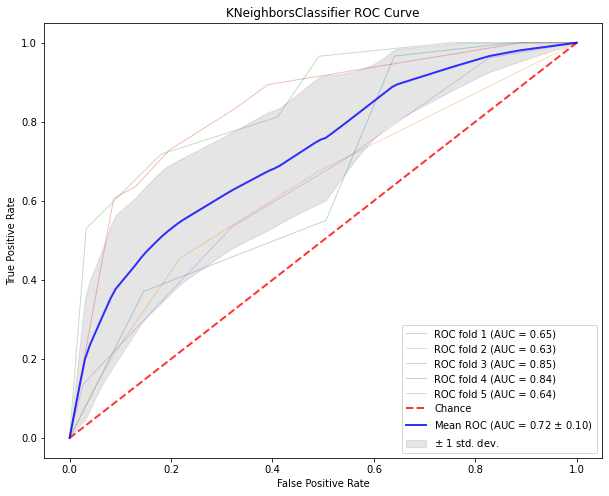

In [37]:
# KNN CV

knn = KNeighborsClassifier(leaf_size=200, n_neighbors=7, p=1)
result_knn = train_tscv(X, y, knn, tscv)

In [38]:
# KNN CV results

result_knn.iloc[:,0:12]

,Sprint,Neg,TN,FN,Pos,TP,FP,Accuracy,Recall,Precision,Recall 0,Precision 0
0,1,84,44,40,94,49,45,0.522472,0.550562,0.521277,0.494382,0.523810
1,2,110,43,67,68,56,12,0.556180,0.455285,0.823529,0.781818,0.390909
2,3,35,31,4,143,113,30,0.808989,0.965812,0.790210,0.508197,0.885714
3,4,53,31,22,125,110,15,0.792135,0.833333,0.880000,0.673913,0.584906
4,5,17,13,4,161,99,62,0.629213,0.961165,0.614907,0.173333,0.764706
5,Mean,59.8,32.4,27.4,118.2,85.4,32.8,0.661798,0.753231,0.725985,0.526329,0.630009


In [39]:
result_knn.iloc[:,[0,12,13,14,15]]

,Sprint,F1,F1 0,Macro F1,AUC
0,1,0.535519,0.508671,0.522095,0.650549
1,2,0.586387,0.521212,0.553800,0.633629
2,3,0.869231,0.645833,0.757532,0.852879
3,4,0.856031,0.626263,0.741147,0.838109
4,5,0.750000,0.282609,0.516304,0.644660
5,Mean,0.719434,0.516917,0.618176,0.723965


# Model Comparison

In [40]:
models = ['LR', 'RF', 'KNN']
comparison = pd.concat([result_lr.iloc[-1],
                        result_rf.iloc[-1],
                        result_knn.iloc[-1]
                       ],
                       axis=1).transpose().reset_index(drop=True)
comparison['Sprint'] = models
comparison.rename(columns = {'Sprint':'Model'}, inplace = True)
comparison[['Model', 'Accuracy', 'Recall', 'Precision', 'Recall 0', 'Precision 0',
           'F1', 'F1 0', 'Macro F1', 'AUC']
          ]

,Model,Accuracy,Recall,Precision,Recall 0,Precision 0,F1,F1 0,Macro F1,AUC
0,LR,0.817978,0.854394,0.854009,0.734495,0.755566,0.852331,0.737624,0.794978,0.888415
1,RF,0.808989,0.83252,0.860732,0.760339,0.724203,0.843644,0.735454,0.789549,0.87247
2,KNN,0.661798,0.753231,0.725985,0.526329,0.630009,0.719434,0.516917,0.618176,0.723965
